In [1]:
# import dependencies

import pandas as pd
from config import api_key
import requests
import os
import math
from datetime import datetime
from config import finn
import finnhub
finnhub_client = finnhub.Client(api_key=finn)
import time
import datetime
now = datetime.datetime.now()
import yfinance as yf
import numpy as np
from scipy.stats import norm
from datetime import date
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import itertools

In [2]:
# url for api key
option_url = 'https://api.tdameritrade.com/v1/marketdata/chains'

In [3]:

# input conditions for options
symbol = input("Ticker")
strikecount = input("Strikecount")
expMonth = input('Exp Month')
contract = input('Contract type PUT, CALL, ALL')
strike = input("Strike Price")

Ticker
Strikecount10
Exp MonthALL
Contract type PUT, CALL, ALLALL
Strike Price


In [4]:
vol = pd.read_csv('Sigma.csv')

In [5]:
common_list = ["AAPL"]

In [6]:
r = 0.02

In [123]:
tickers = pd.read_csv("S&P copy.csv")["S&P"].tolist()
optionable = pd.read_csv("Stocks.csv")["Tickers"].tolist()
common_list = set(tickers).intersection(optionable)

In [121]:
# Current Price

arb = {}



for symbol in common_list:
    
    sigma  = vol.loc[vol["Unnamed: 0"] == f"{symbol}"]["Sigma"].tolist()[0]
    
    div  = vol.loc[vol["Unnamed: 0"] == f"{symbol}"]["Div"].tolist()[0]

    # Set the start and end date
    start_date = '2023-01-01'

    t = date.today()

    t = str(t)

    # Set the start and end date
    start_date = '2023-01-01'

    t = date.today()

    t = str(t)

    # Get the data
    data = yf.download(symbol, start_date, t)

    try:
        close = data.tail(1)["Close"].values[0]
    except:
        continue



    #uses api key to extract data
    params = {'apikey':api_key,
             'symbol':symbol,
             'contractType': contract,
              'strikeCount': strikecount,
              'includeQuotes': False,
              'stratgey': 'SINGLE',
              'expMonth': expMonth,
              'optionType': 'S'


             }

    content = requests.get(url = option_url, params=params)

    data = content.json()




    dates_ref = []

    int_year = now.year
    int_month = now.month
    int_day = now.day

    for i in data['putExpDateMap']:
        dates_ref.append(i)

    for i in dates_ref:

        #create outline for 
        df = {}
        date_now = i[:10]
        volume = []
        theta = []
        gamma = []
        delta = []
        interest = []

        #iterate through each strike
        for strike in data["putExpDateMap"][i]:
            df[strike] = {'Put': 0, "Call": 0, 'Call - Volume' : 0, 'Put - Volume' : 0, 'IV': 0}
            ask = data["putExpDateMap"][i][strike][0]["ask"]
            
            bid = data["putExpDateMap"][i][strike][0]["bid"]
            
            
            df[strike]['Put'] = (ask + bid) / 2
            df[strike]['Put - Volume'] = data["putExpDateMap"][i][strike][0]["totalVolume"]
            df[strike]['IV'] = data['volatility']

        for strike in data["callExpDateMap"][i]:
            
            if strike not in df:
                df[strike] = {'Put': 0, "Call": 0, 'Call - Volume' : 0, 'Put - Volume' : 0, 'IV': 0}
            
            ask = data["callExpDateMap"][i][strike][0]["ask"]
            
            bid = data["callExpDateMap"][i][strike][0]["bid"]

            df[strike]['Call'] = (ask + bid) / 2
            df[strike]['Call - Volume'] = data["callExpDateMap"][i][strike][0]["totalVolume"]
            df[strike]['IV'] = data['volatility']



        strike_date = i.split('-')

        year = int(strike_date[0])

        month = int(strike_date[1])

        day = int(strike_date[2].split(':')[0])
        
        count = int(strike_date[2].split(':')[1]) / 365
        
        label = i.split(":")[0]

        #convert to dataframe
        option_df = pd.DataFrame.from_dict(df, orient='index')
        
        option_df = option_df.replace(np.nan, 0)

        for row, i in option_df.iterrows():


            K = float(row)

            C = i['Call']

            P = i['Put']

            t = 'p'
            
            # obtain true put value using black scholes formula

            true_put = blackScholes(r, close, K, count, sigma, t, div)

            t = 'c'
            
            # obtain true call value using black scholes formula

            true_call = blackScholes(r, close, K, count, sigma, t, div)

            diff_put = true_put - P

            diff_call = true_call - C
            
            ### assigning initial volatility estimate for input in Newton_rap procedure
            sigma = 0.3
            
            sigma_put = sigma - diff_put / vega(close, K, count, r, sigma, div)
            
            sigma_call = sigma - diff_call / vega(close, K, count, r, sigma, div)

            arb[f'{label} - {K}'] = {'Date': label, 'Strike': K, 'Put': df[row]['Put'], 'True Put' : true_put, 'Call': df[row]['Call'], 'True Call': true_call, 'Symbol': symbol, 'Call - Volume': df[row]['Call - Volume'], 'Put - Volume': df[row]['Put - Volume'], 'Price': close, "IV_Put": sigma_put, "IV_Call": sigma_call}

options_df = pd.DataFrame.from_dict(arb, orient='index')


IV_dict = {"Linear_Put": [], 'Linear_Call': []}

dates = options_df["Date"].unique().tolist()

for date1 in dates:

    test = options_df.loc[options_df["Date"] == date1].sort_values(by='Strike')
    

    add = linear_func(test, 'IV_Call')

    IV_dict["Linear_Call"] = IV_dict["Linear_Call"] + add

    add = linear_func(test, 'IV_Put')

    IV_dict["Linear_Put"] = IV_dict["Linear_Put"] + add
    
options_df["Linear_Put"] = IV_dict["Linear_Put"]
options_df["Linear_Call"] = IV_dict["Linear_Call"]

options_df["Diff_IV_Put"] = options_df["Linear_Put"] - options_df["IV_Put"]
options_df["Diff_IV_Call"] = options_df["Linear_Call"] - options_df["IV_Call"]

options_df


[*********************100%***********************]  1 of 1 completed


,Date,Strike,Put,True Put,Call,True Call,Symbol,Call - Volume,Put - Volume,Price,IV_Put,IV_Call,Linear_Put,Linear_Call,Diff_IV_Put,Diff_IV_Call
2023-03-24 - 149.0,2023-03-24,149.0,0.115,0.309453,10.625,7.959629,AAPL,129,4421,157.399994,0.109219,2.915040,6.134584,2.108136,6.025365,-0.806904
2023-03-24 - 150.0,2023-03-24,150.0,0.145,0.097964,9.600,6.748305,AAPL,1226,21103,157.399994,0.330143,2.127460,4.991301,1.975956,4.661159,-0.151504
2023-03-24 - 152.5,2023-03-24,152.5,0.290,0.358559,7.300,4.509311,AAPL,1956,16030,157.399994,0.280122,1.109129,2.133095,1.645506,1.852972,0.536377
2023-03-24 - 155.0,2023-03-24,155.0,0.590,0.991587,5.025,2.642750,AAPL,8562,39260,157.399994,0.223482,0.753911,-0.725112,1.315056,-0.948594,0.561144
2023-03-24 - 157.5,2023-03-24,157.5,1.175,2.161716,3.125,1.313290,AAPL,49102,47018,157.399994,0.123682,0.623738,-3.583319,0.984605,-3.707000,0.360867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19 - 160.0,2025-12-19,160.0,23.575,121.224554,37.225,0.005239,AAPL,77,11,157.399994,-81.765070,31.579634,-95.480989,32.773341,-13.715918,1.193707
2025-12-19 - 165.0,2025-12-19,165.0,25.850,125.955889,34.450,0.004213,AAPL,2,2,157.399994,-101.115426,35.196390,-112.774295,36.382909,-11.658869,1.186519
2025-12-19 - 170.0,2025-12-19,170.0,28.275,130.687436,32.600,0.003399,AAPL,4,20,157.399994,-124.529702,40.031738,-130.067601,39.992478,-5.537899,-0.039260
2025-12-19 - 175.0,2025-12-19,175.0,30.850,135.419148,29.925,0.002751,AAPL,2,304,157.399994,-152.758439,44.097361,-147.360907,43.602046,5.397531,-0.495315


In [155]:
# Current Price

final_df = pd.DataFrame()

for symbol in common_list:
    
    arb = {}
    
    sigma  = vol.loc[vol["Unnamed: 0"] == f"{symbol}"]["Sigma"].tolist()[0]
    
    div  = vol.loc[vol["Unnamed: 0"] == f"{symbol}"]["Div"].tolist()[0]

    # Set the start and end date
    start_date = '2023-01-01'

    t = date.today()

    t = str(t)

    # Set the start and end date
    start_date = '2023-01-01'

    t = date.today()

    t = str(t)

    # Get the data
    data = yf.download(symbol, start_date, t)

    try:
        close = data.tail(1)["Close"].values[0]
    except:
        continue



    #uses api key to extract data
    params = {'apikey':api_key,
             'symbol':symbol,
             'contractType': contract,
              'strikeCount': strikecount,
              'includeQuotes': False,
              'stratgey': 'SINGLE',
              'expMonth': expMonth,
              'optionType': 'S'


             }

    content = requests.get(url = option_url, params=params)

    data = content.json()
    
    if data['status'] == 'FAILED':
        continue




    dates_ref = []

    int_year = now.year
    int_month = now.month
    int_day = now.day

    for i in data['putExpDateMap']:
        dates_ref.append(i)

    for i in dates_ref:

        #create outline for 
        df = {}
        date_now = i[:10]
        volume = []
        theta = []
        gamma = []
        delta = []
        interest = []

        #iterate through each strike
        for strike in data["putExpDateMap"][i]:
            df[strike] = {'Put': 0, "Call": 0, 'Call - Volume' : 0, 'Put - Volume' : 0, 'IV - Put': 0, 'IV - Call': 0}
            ask = data["putExpDateMap"][i][strike][0]["ask"]
            
            bid = data["putExpDateMap"][i][strike][0]["bid"]
            
            
            df[strike]['Put'] = (ask + bid) / 2
            df[strike]['Put - Volume'] = data["putExpDateMap"][i][strike][0]["totalVolume"]
            df[strike]['IV - Put'] = data["putExpDateMap"][i][strike][0]['volatility']

        for strike in data["callExpDateMap"][i]:
            
            if strike not in df:
                df[strike] = {'Put': 0, "Call": 0, 'Call - Volume' : 0, 'Put - Volume' : 0, 'IV - Call': 0, 'IV - Put': 0}
            
            ask = data["callExpDateMap"][i][strike][0]["ask"]
            
            bid = data["callExpDateMap"][i][strike][0]["bid"]

            df[strike]['Call'] = (ask + bid) / 2
            df[strike]['Call - Volume'] = data["callExpDateMap"][i][strike][0]["totalVolume"]
            df[strike]['IV - Call'] = data["callExpDateMap"][i][strike][0]['volatility']



        strike_date = i.split('-')

        year = int(strike_date[0])

        month = int(strike_date[1])

        day = int(strike_date[2].split(':')[0])
        
        count = int(strike_date[2].split(':')[1]) / 365
        
        label = i.split(":")[0]

        #convert to dataframe
        option_df = pd.DataFrame.from_dict(df, orient='index')
        
        option_df = option_df.replace(np.nan, 0)

        for row, i in option_df.iterrows():


            K = float(row)

            C = i['Call']

            P = i['Put']

            t = 'p'
            
            # obtain true put value using black scholes formula

            true_put = blackScholes(r, close, K, count, sigma, t, div)

            t = 'c'
            
            # obtain true call value using black scholes formula

            true_call = blackScholes(r, close, K, count, sigma, t, div)
            
            if (df[row]['IV - Put'] == 'NaN'):
                continue
                
            elif (df[row]['IV - Call'] == 'NaN'):
                continue

            diff_put = true_put - P

            diff_call = true_call - C

            arb[f'{label} - {K}'] = {'Date': label, 'Strike': K, 'Put': df[row]['Put'], 'True Put' : true_put, 'Call': df[row]['Call'], 'True Call': true_call, 'Symbol': symbol, 'Call - Volume': df[row]['Call - Volume'], 'Put - Volume': df[row]['Put - Volume'], 'Price': close, "IV_Put": df[row]['IV - Put'], "IV_Call": df[row]['IV - Call']}

    options_df = pd.DataFrame.from_dict(arb, orient='index')


    IV_dict = {"Linear_Put": [], 'Linear_Call': []}

    dates = options_df["Date"].unique().tolist()

    for date1 in dates:

        test = options_df.loc[options_df["Date"] == date1].sort_values(by='Strike')


        add = linear_func(test, 'IV_Call')

        IV_dict["Linear_Call"] = IV_dict["Linear_Call"] + add

        add = linear_func(test, 'IV_Put')

        IV_dict["Linear_Put"] = IV_dict["Linear_Put"] + add

    options_df["Linear_Put"] = IV_dict["Linear_Put"]
    options_df["Linear_Call"] = IV_dict["Linear_Call"]

    options_df["Diff_IV_Put"] = options_df["Linear_Put"] - options_df["IV_Put"]
    options_df["Diff_IV_Call"] = options_df["Linear_Call"] - options_df["IV_Call"]
    
    final_df = pd.concat([options_df, final_df])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

KeyError: 'status'

<AxesSubplot:xlabel='Strike'>

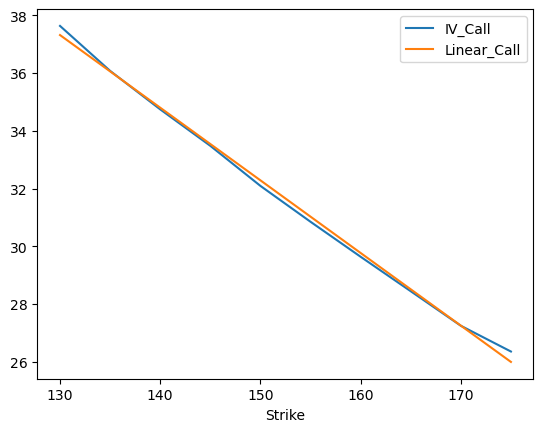

In [118]:
graph = options_df.loc[options_df['Date'] == "2023-06-16"]

graph.plot(x='Strike', y=['IV_Call','Linear_Call'])

<AxesSubplot:xlabel='Strike'>

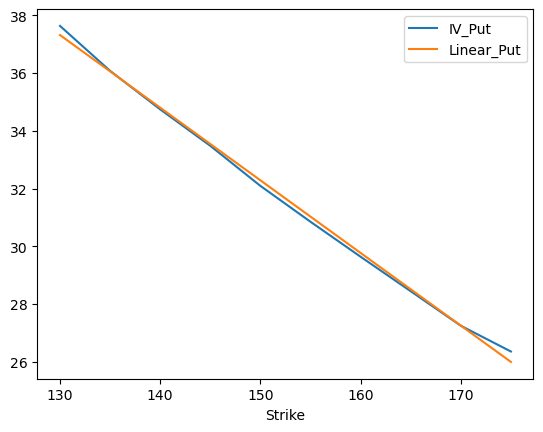

In [119]:
graph.plot(x='Strike', y=['IV_Put', 'Linear_Put'])

In [8]:
def blackScholes(r, S, K, T, sigma, t, p):
    d1 = (np.log(S/K) + (r - p + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == "c":
        price = S*np.exp(-p*T)*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    elif t == "p":
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*np.exp(-p*T)*norm.cdf(-d1, 0, 1)
    return price


In [9]:
 

N_prime = norm.pdf


def vega(S, K, T, r, sigma, p):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''

    ### calculating d1 from black scholes
    d1 = (np.log(S/K) + (r - p + sigma**2/2)*T)/(sigma*np.sqrt(T))

    
    vega = S  * np.sqrt(T) * N_prime(d1)
    return vega

In [63]:
def implied_volatility_call(C, S, K, T, r, div, t, tol=0.0001,
                            max_iterations=100):
    '''

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''


    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = blackScholes(r, S, K, T, sigma, t, div) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma, div)
        
    if np.isnan(sigma):
        print(diff / vega(S, K, T, r, sigma, div))

    return sigma

In [64]:
def linear_func(test, option):
    
    model = LinearRegression()
    
    min_test = min(test[option])
    
    s = test.loc[test[option] == min_test]["Strike"].tolist()[0]

    down_df = test.loc[test["Strike"] <= s]

    up_df = test.loc[test["Strike"] >= s]


    # Down


    time = np.array(down_df["Strike"]).reshape(-1, 1)

    predict = np.array(down_df[option]).reshape(-1, 1)

    model.fit(time, predict)

    y_pred = model.predict(time)

    # Up

    time = np.array(up_df["Strike"]).reshape(-1, 1)

    predict = np.array(up_df[option]).reshape(-1, 1)

    model.fit(time, predict)

    y_pred_2 = model.predict(time)

    # Combine

    down = list(itertools.chain(*y_pred))

    up = list(itertools.chain(*y_pred_2))

    r = up[0]

    up.remove(r)

    total = down + up
    
    return total